In [1]:
# (re-)load layers
%run modules.ipynb

In [2]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [4]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

In [5]:
def f(x):
    y = x**2 
    return y
X = np.linspace(-1, 1, num=2)[:, np.newaxis]
Y = f(X)

In [7]:
print(Y.shape, X.shape)
# print(X)

(2, 1) (2, 1)


In [8]:
n = 100
net = Sequential()
net.add(Linear(1, n))
net.add(ReLU())

deep = 1
for i in range(deep):
    net.add(Linear(n, n) )
    net.add(ReLU())

net.add(Linear(n, 1))
print(net)

Linear 1 -> 100
ReLU
Linear 100 -> 100
ReLU
Linear 100 -> 1



In [9]:
def get_history(net, batch_size=100, n_epoch=100, lr = 1e-2, momentum = 0.9, verbose=True ):
    # Iptimizer params
    criterion = MSECriterion()
    optimizer_config = {'learning_rate' : lr, 'momentum': momentum}
    optimizer_state = {}

    # Looping params
    n_epoch = n_epoch
    batch_size = batch_size
    
    loss_history = []

    for i in tqdm(range(n_epoch)):
        try:
            if (i+1 %10) == 0: 
                optimizer_config['learning_rate'] = optimizer_config['learning_rate'] / 2

            for x_batch, y_batch in get_batches((X, Y), batch_size):

                    net.train()

                    net.zeroGradParameters()

                    # Forward
                    predictions = net.forward(x_batch)
                    loss = criterion.forward(predictions, y_batch)

                    # Backward
                    dp = criterion.backward(predictions, y_batch)
                    net.backward(x_batch, dp)

                    # Update weights
                    sgd_momentum(net.getParameters(), 
                                 net.getGradParameters(), 
                                 optimizer_config,
                                 optimizer_state)   

                    loss_history.append(loss)

                    net.evaluate() 
                    X_full = np.linspace(-1, 1, num=1000)[:, np.newaxis]
                    predictions = net.forward(X_full)
                          
            
            # Visualize
            if verbose:
                display.clear_output(wait=True)
                print('Current loss: %f' % loss) 
        #             plt.figure(figsize=(8, 6))
                plt.figure(figsize=(18, 18))      
                plt.subplot(431)
                plt.title("Training loss")
                plt.xlabel("#iteration")
                plt.ylabel("loss")
                plt.plot(loss_history, 'b')

                plt.subplot(432)
                plt.title("Aproximation")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.plot(X_full, predictions, 'b')
                plt.plot(X, Y, 'o',  'g')

                deep = len(net.modules)
                n=0
                pred = X_full.copy()

                for i in range(deep):
                    pred = net.modules[i].forward(pred)
                    if net.modules[i].__repr__()=='ReLU' or i==deep-1:
                        plt.subplot(430+n+4)
                        n+=1
                        plt.title(str(i)+' '+net.modules[i].__repr__()+" layer")
                        plt.xlabel("X")
                        plt.ylabel("Y")
                        plt.plot(X_full, pred[:,:5])

                plt.show()
            
        except KeyboardInterrupt:
                return loss_history

             
    return loss_history

 67%|██████▋   | 2/3 [00:01<00:00,  1.90it/s]

(1,) (1, 2) (2,)
(100,) (100, 2) (2,)
(100,) (100, 2) (2,)
Current loss: 0.174412


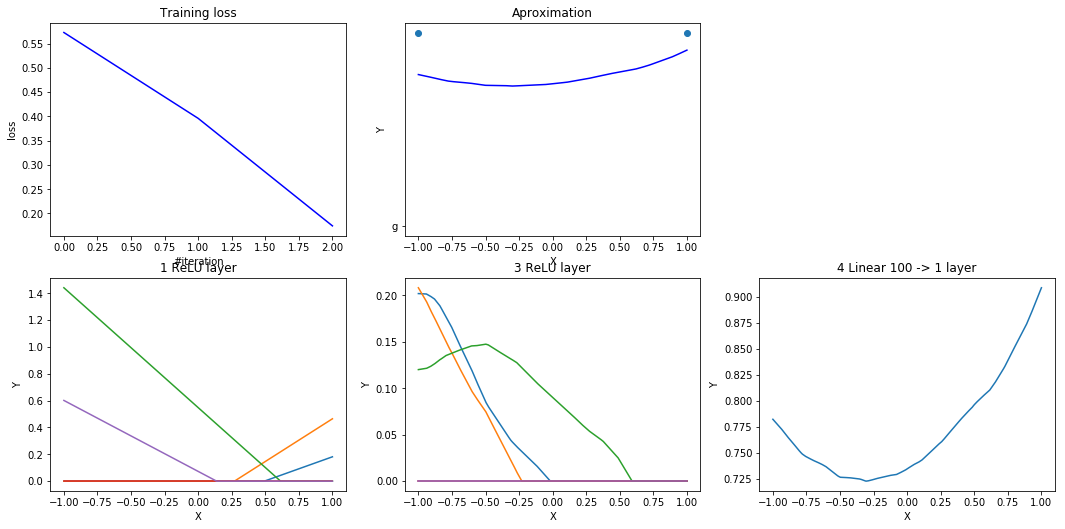

100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


In [14]:
history = get_history(net, 10, n_epoch=3, momentum=0.8, lr=1e-2, verbose=True)

In [11]:
X_full = np.linspace(-1, 1, num=1000)[:, np.newaxis]
deep = len(net.modules)
pred = X_full.copy()
for i in range(deep):
    pred = net.modules[i].forward(pred)

In [12]:
def layer_visualization():
    
    net.evaluate() 
    X = np.linspace(-1, 1, num=100)[:, np.newaxis]
    pred = X.copy()
    deep = len(net.modules)
    n=0
    plt.figure(figsize=(16, 10))
    for i in range(deep):
        pred = net.modules[i].forward(pred)
        if net.modules[i].__repr__()=='ReLU' or i==deep-1:
            plt.subplot(330+n+1)
            n+=1
            plt.title(str(i)+' '+net.modules[i].__repr__()+" layer")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.plot(X, pred[:, :10])
    
#     plt.show()

    

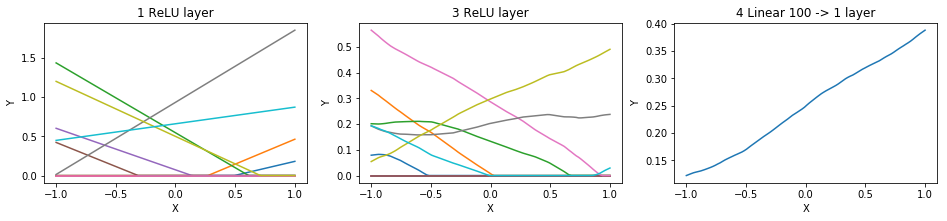

In [13]:
layer_visualization()

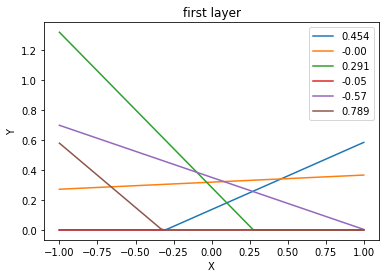

In [47]:
def layer_visualization(weights, bias, final_weights):
    
    for i, (W, b, W_f) in enumerate(zip(weights.flatten(), bias, final_weights.flatten())):
        plt.title("first layer")
        plt.xlabel("X")
        plt.ylabel("Y")
        X = np.linspace(-1, 1, num=100)[:, np.newaxis]
        Y = np.maximum(W*X+b,0)
        plt.plot(X, Y, label = str(W_f)[:5])
        plt.legend()
#     plt.show()
                    
layer_visualization(*net.modules[0].getParameters(), net.modules[2].getParameters()[0])    

In [233]:
net.modules[2].getParameters()[0]

array([[ 0.55976245,  0.63941414,  0.30524722, -0.1053666 ,  0.08202103,
         0.37194014]])

In [196]:
((X @ net.modules[0].W.T + net.modules[0].b)[:,3]<=0).all()

True

In [208]:
net.modules[0].b

array([-1.65721217, -1.44143536, -0.33690059, -0.58493525, -1.39736881])

In [199]:
from sympy import *

In [203]:
x, y, z = symbols('x y z')

In [257]:
diff(exp(x**2), x)

2*x*exp(x**2)